In [5]:
import sys
sys.path.append("./../")

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from modules.vqvae.model import VQVAE
from datasets.cub import CubDataset, cub_collate
from config import Config

In [8]:
def show(img, figsize=(14, 10)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [9]:
CONFIG = Config(local=True, model_path="models/vqvae_i128_e512x8138/")
CONFIG.load_config()

train_dataset = CubDataset(root_img_path=CONFIG.root_img_path,
                           root_text_path=CONFIG.root_text_path,
                           imgs_list_file_path=CONFIG.imgs_list_file_path,
                           img_size=CONFIG.img_size)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=CONFIG.BATCH_SIZE,
                          shuffle=True,
                          collate_fn=cub_collate)

In [10]:
imgs, _ = next(iter(train_loader))

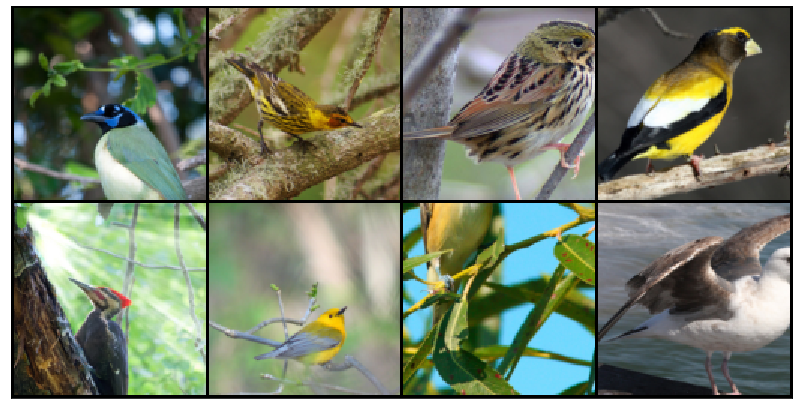

In [11]:
show(make_grid(imgs.data, nrow=4))

In [12]:
model = VQVAE(num_embeddings=CONFIG.vqvae_num_embeddings,
              embedding_dim=CONFIG.vqvae_embedding_dim,
              commitment_cost=CONFIG.vqvae_commitment_cost,
              decay=CONFIG.vqvae_decay,
              num_x2downsamples=CONFIG.vqvae_num_x2downsamples)

model.load_model(root_path=CONFIG.save_model_path, model_name="VQVAE")
_ = model.eval()

In [13]:
_, reconstructions, _ = model(imgs)

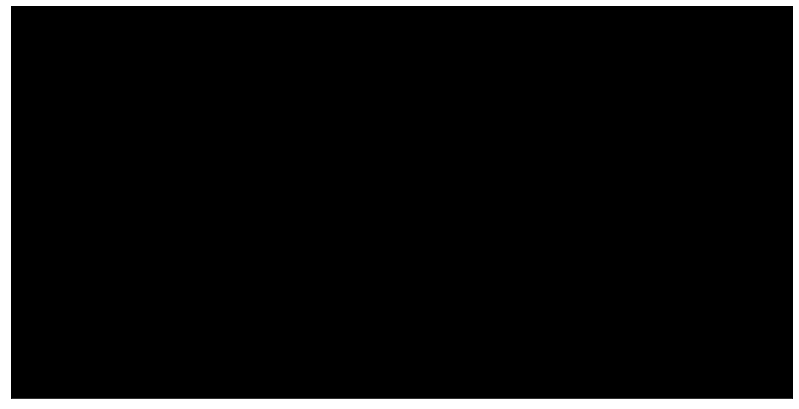

In [14]:
# rec_normilized = reconstructions / reconstructions.max(dim=1)[0].unsqueeze(1).repeat(1,3,1,1)
rec_normilized = reconstructions / reconstructions.max()
show(make_grid(rec_normilized.data, nrow=4))

In [15]:
quantized, (encodings, encoding_codes) = model.encode(imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


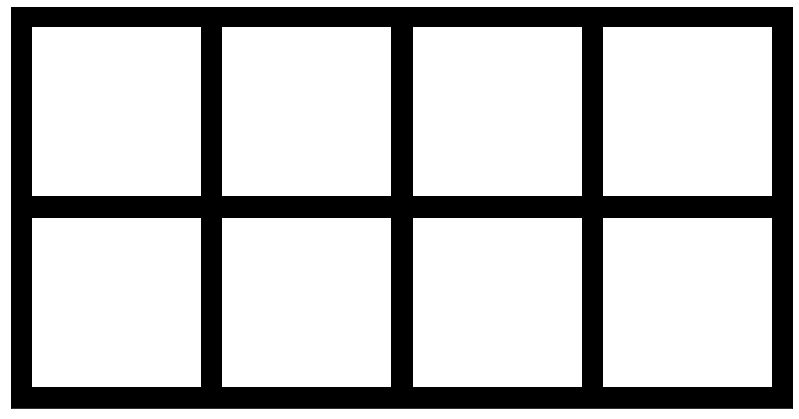

In [16]:
show(make_grid(encoding_codes.unsqueeze(1).data, nrow=4))

In [11]:
import torch

index_m = encoding_codes[2].unsqueeze(0)

index_m_new = torch.empty_like(index_m).copy_(index_m)
index_m_new[0, 10:22, 10:22] = 12

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


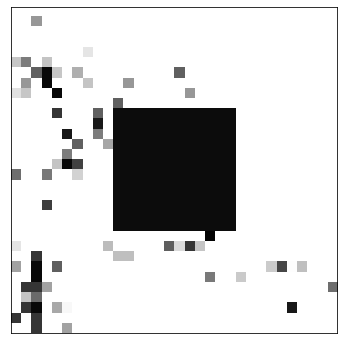

In [12]:
show(make_grid(index_m_new.data, nrow=4), figsize=(6, 6))

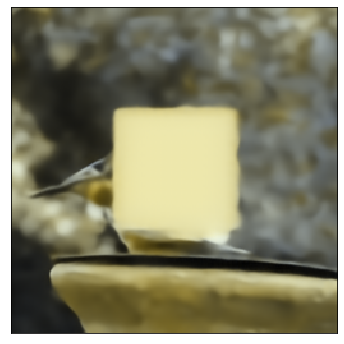

In [13]:
show(make_grid(model.decode_by_index_mask(index_m_new).data, nrow=4), figsize=(6, 6))

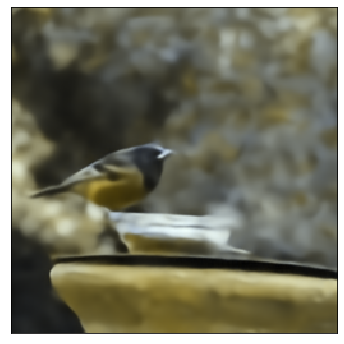

In [14]:
show(make_grid(model.decode_by_index_mask(index_m).data, nrow=4), figsize=(6, 6))